In [202]:
import pandas as pd, numpy as np, datetime as dt, os
import operator

# There are 2 Main Sources of Data:
* Data World Data
    * hot100.csv
        * complete Hot 100 Data from _ to _. corresponds to 29,154 Songs
    * audioFeatures.csv
        * Spotify Audio Features of Billboard Songs corresponds to 28,377 Songs
* Kaggle Data
    * billboardHot100_1999-2019.csv
        * Incomplete Hot 100 Data from 1999 to 2019
    * songAttributes_1999-2019.csv
        * Spotify Attributes for 150,000+ songs
        * They do not have a direct correspondence with the Hot 100 Songs. But provide a meaningful sample of Songs.
            * If I recreate the distribution of songs by top level Genre in the Billboard Hot100 I should be able to get a meaningful sample of songs to compare against the more popular Songs

<h1 style="color: #23ADAA" > GOALS:</h1>
<ol>
<li> Locate the Songs with Missing Attributes in audioFeatures.csv</li>
<li> Compare those missing against Songs in the other song Attributes file.</li>
<li> Create a Structured Data Base with Tables corresponding to:
    <ul>
    <li> Time Series of Songs over each week with the wanted Spotify attributes and a column for Top level Genre.</li>
    <li> A Sample of Songs that were released in the same time period (1999 - 2019) and Have the Same Distribution of the Top Level Genre as The Hot 100. </li>
    </ul>
</ol>
<br>
<p>These tables will help generate a Horse Race Chart that will show Chart Progression Over Time and Radar Charts Graphing the Hot 100 Attributes Against The Sample of Other Songs. There will additionally be aggregate statistics about the overall year in music on how music was structured and experienced given the attributes of popular songs and all other songs we have.</p>

In [3]:
# Main Data
df_hot = pd.read_csv("hot100.csv")

In [4]:
df_hot.shape

(325695, 10)

In [6]:
df_hot.head()

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1963-0...,6/1/1963,11,Still,Bill Anderson,StillBill Anderson,1.0,17.0,11.0,8.0
1,http://www.billboard.com/charts/hot-100/1967-0...,1/7/1967,11,Coming Home Soldier,Bobby Vinton,Coming Home SoldierBobby Vinton,1.0,17.0,11.0,8.0
2,http://www.billboard.com/charts/hot-100/1971-0...,7/3/1971,11,She's Not Just Another Woman,The 8th Day,She's Not Just Another WomanThe 8th Day,1.0,17.0,11.0,8.0
3,http://www.billboard.com/charts/hot-100/1975-1...,11/29/1975,11,Saturday Night,Bay City Rollers,Saturday NightBay City Rollers,1.0,17.0,11.0,8.0
4,http://www.billboard.com/charts/hot-100/1979-0...,9/29/1979,11,Pop Muzik,M,Pop MuzikM,1.0,17.0,11.0,8.0


In [7]:
df_hot.WeekID = pd.to_datetime(df_hot.WeekID)

In [9]:
df_hot.sort_values("WeekID")

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
17651,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,72,Stupid Cupid,Connie Francis,Stupid CupidConnie Francis,1.0,NaN,72.0,1.0
6984,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,54,Nel Blu Dipinto Di Blu (Volaré),Domenico Modugno,Nel Blu Dipinto Di Blu (Volaré)Domenico Modugno,1.0,NaN,54.0,1.0
22741,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,87,Jealousy,Kitty Wells,JealousyKitty Wells,1.0,NaN,87.0,1.0
294973,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,5,When,Kalin Twins,WhenKalin Twins,1.0,NaN,5.0,1.0
318351,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,79,The Bird On My Head,David Seville,The Bird On My HeadDavid Seville,1.0,NaN,79.0,1.0
...,...,...,...,...,...,...,...,...,...,...
309370,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,26,Happy Holiday / The Holiday Season,Andy Williams,Happy Holiday / The Holiday SeasonAndy Williams,NaN,NaN,NaN,NaN
309369,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,25,For The Night,Pop Smoke Featuring Lil Baby & DaBaby,For The NightPop Smoke Featuring Lil Baby & Da...,NaN,NaN,NaN,NaN
309427,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,83,Love You Like I Used To,Russell Dickerson,Love You Like I Used ToRussell Dickerson,NaN,NaN,NaN,NaN
309348,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,4,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,NaN,NaN,NaN,NaN


In [16]:
# We only want data from 1999 - 2020
df_hot = df_hot[(df_hot.WeekID >= dt.datetime(1999, 1, 1)) & (df_hot.WeekID < dt.datetime(2020, 1, 1))].reset_index(drop=True)

In [17]:
df_hot.shape

(109600, 10)

In [20]:
df_hot

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1999-0...,1999-03-27,11,All Night Long,Faith Evans Featuring Puff Daddy,All Night LongFaith Evans Featuring Puff Daddy,1.0,19.0,11.0,8.0
1,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,11.0,8.0
2,http://www.billboard.com/charts/hot-100/2005-1...,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,11.0,8.0
3,http://www.billboard.com/charts/hot-100/2010-0...,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,5.0,8.0
4,https://www.billboard.com/charts/hot-100/2018-...,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...
109595,https://www.billboard.com/charts/hot-100/2018-...,2018-03-17,38,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,6.0
109596,https://www.billboard.com/charts/hot-100/2018-...,2018-03-24,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,7.0
109597,https://www.billboard.com/charts/hot-100/2018-...,2018-03-31,36,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,34.0,28.0,8.0
109598,https://www.billboard.com/charts/hot-100/2018-...,2018-04-07,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,36.0,28.0,9.0


In [21]:
df_hot = df_hot.loc[:, ["Song", "Performer", "Week Position", "WeekID","Previous Week Position", "Peak Position", "Weeks on Chart", "Instance", "SongID"]]

In [22]:
df_hot

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID
0,All Night Long,Faith Evans Featuring Puff Daddy,11,1999-03-27,19.0,11.0,8.0,1.0,All Night LongFaith Evans Featuring Puff Daddy
1,Dance Monkey,Tones And I,11,2019-12-07,19.0,11.0,8.0,1.0,Dance MonkeyTones And I
2,Run It!,Chris Brown,11,2005-10-15,24.0,11.0,8.0,1.0,Run It!Chris Brown
3,Baby,Justin Bieber Featuring Ludacris,12,2010-03-27,14.0,5.0,8.0,1.0,BabyJustin Bieber Featuring Ludacris
4,Pray For Me,The Weeknd & Kendrick Lamar,12,2018-04-07,10.0,7.0,8.0,1.0,Pray For MeThe Weeknd & Kendrick Lamar
...,...,...,...,...,...,...,...,...,...
109595,You Make It Easy,Jason Aldean,38,2018-03-17,38.0,28.0,6.0,1.0,You Make It EasyJason Aldean
109596,You Make It Easy,Jason Aldean,34,2018-03-24,38.0,28.0,7.0,1.0,You Make It EasyJason Aldean
109597,You Make It Easy,Jason Aldean,36,2018-03-31,34.0,28.0,8.0,1.0,You Make It EasyJason Aldean
109598,You Make It Easy,Jason Aldean,34,2018-04-07,36.0,28.0,9.0,1.0,You Make It EasyJason Aldean


In [27]:
df_hot = df_hot.assign(Week_No = lambda x: x.WeekID.apply(dt.datetime.strftime, format="%U"))

In [29]:
df_hot = df_hot.sort_values(["WeekID", "Week Position"]).reset_index(drop=True)

In [31]:
df_hot.Week_No.value_counts()

43    2100
24    2100
22    2100
06    2100
23    2100
30    2100
16    2100
49    2100
07    2100
18    2100
04    2100
26    2100
35    2100
17    2100
48    2100
46    2100
03    2100
02    2100
15    2100
27    2100
37    2100
05    2100
34    2100
50    2100
45    2100
25    2100
28    2100
21    2100
31    2100
39    2100
14    2100
19    2100
32    2100
11    2100
40    2100
08    2100
41    2100
09    2100
33    2100
12    2100
10    2100
42    2100
29    2100
38    2100
36    2100
20    2100
47    2100
44    2100
01    2100
13    2100
51    2100
00    1800
52     700
Name: Week_No, dtype: int64

In [32]:
df_hot.head(10)

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No
0,I'm Your Angel,R. Kelly & Celine Dion,1,1999-01-02,1.0,1.0,5.0,1.0,I'm Your AngelR. Kelly & Celine Dion,00
1,Nobody's Supposed To Be Here,Deborah Cox,2,1999-01-02,2.0,2.0,14.0,1.0,Nobody's Supposed To Be HereDeborah Cox,00
2,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00
3,...Baby One More Time,Britney Spears,4,1999-01-02,5.0,4.0,7.0,1.0,...Baby One More TimeBritney Spears,00
4,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00
5,From This Moment On,Shania Twain,6,1999-01-02,4.0,4.0,5.0,1.0,From This Moment OnShania Twain,00
6,Doo Wop (That Thing),Lauryn Hill,7,1999-01-02,7.0,1.0,8.0,1.0,Doo Wop (That Thing)Lauryn Hill,00
7,Trippin',Total Featuring Missy Elliott,8,1999-01-02,12.0,8.0,9.0,1.0,Trippin'Total Featuring Missy Elliott,00
8,Have You Ever?,Brandy,9,1999-01-02,9.0,9.0,5.0,1.0,Have You Ever?Brandy,00
9,Love Like This,Faith Evans,10,1999-01-02,8.0,7.0,8.0,1.0,Love Like ThisFaith Evans,00


In [39]:
# Number of Unique Songs
df_hot.SongID.unique().shape

(8307,)

## Merging With Attributes

In [60]:
# Interested in Top 20 of the Top100
top20_df = df_hot[df_hot["Week Position"] <= 20]

In [33]:
attr_df = pd.read_csv("audioFeatures.csv")

In [42]:
attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28492 entries, 0 to 28491
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SongID                     28492 non-null  object 
 1   Performer                  28492 non-null  object 
 2   Song                       28492 non-null  object 
 3   spotify_genre              27260 non-null  object 
 4   spotify_track_id           23743 non-null  object 
 5   spotify_track_preview_url  14164 non-null  object 
 6   spotify_track_album        23737 non-null  object 
 7   spotify_track_explicit     23743 non-null  object 
 8   spotify_track_duration_ms  23743 non-null  float64
 9   spotify_track_popularity   23743 non-null  float64
 10  danceability               23680 non-null  float64
 11  energy                     23680 non-null  float64
 12  key                        23680 non-null  float64
 13  loudness                   23680 non-null  flo

In [35]:
attr_df.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [44]:
attr_df.drop(["spotify_track_id", "spotify_track_preview_url"], axis=1, inplace=True)

In [61]:
full_df = pd.merge(top20_df, attr_df, "left", on="SongID")

In [62]:
missing_songs = full_df[full_df.liveness.isnull()].SongID.unique()

In [63]:
missing_songs.shape

(172,)

### Additional Data Sources

In [68]:
billboard_add = pd.read_csv("billboardHot100_1999-2019.csv", index_col=0)

In [69]:
billboard_add.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN
4,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN


In [70]:
billboard_add.Week = pd.to_datetime(billboard_add.Week)

In [75]:
features_add = pd.read_csv("songAttributes_1999-2019.csv", index_col=0)

In [76]:
features_add

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,name,popularity,speechiness,tempo,timesignature,valence
0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365
1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408
2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370
3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183
4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.333000,No.6 Collaborations Project,Ed Sheeran,0.747,200733,0.649,False,0.000000,0.1720,-6.218,0,Nothing On You (feat. Paulo Londra & Dave),80,0.2190,88.011,4,0.840
115,0.314000,No.6 Collaborations Project,Ed Sheeran,0.469,204507,0.631,False,0.000000,0.1400,-6.569,0,I Don't Want Your Money (feat. H.E.R.),74,0.0853,91.418,4,0.763
116,0.467000,No.6 Collaborations Project,Ed Sheeran,0.778,212307,0.590,False,0.000000,0.0902,-5.548,1,1000 Nights (feat. Meek Mill & A Boogie Wit da...,75,0.2700,97.995,4,0.515
117,0.110000,No.6 Collaborations Project,Ed Sheeran,0.726,190293,0.731,False,0.000003,0.0928,-6.304,0,Way To Break My Heart (feat. Skrillex),73,0.1590,170.125,4,0.430


In [78]:
features_add = features_add.assign(SongID = lambda x: x.name + x.artist)

In [120]:
pat = list(missing_songs)
pat.sort()

In [121]:
pattern = "|".join(pat)

In [123]:
pattern = pattern.replace("*", "")

In [125]:
charters_with_avaiable_attributes = features_add[(features_add.SongID.str.contains(pattern))]

C:\Users\Kyle\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [128]:
charters_with_avaiable_attributes.SongID.unique()

array(["Don't Wanna TryFrankie J", 'Do I Make You ProudTaylor Hicks',
       'Freek-A-LeekPetey Pablo', 'CrushDavid Archuleta',
       'CircusBritney Spears', 'Oops!...I Did It AgainBritney Spears',
       "Don't Wanna Go HomeJason Derulo", 'DNA.Kendrick Lamar',
       'Rudolph The Red-Nosed ReindeerGene Autry', 'BerzerkEminem',
       'Party In The U.S.A.Miley Cyrus', '24K MagicBruno Mars',
       'Born This WayLady Gaga', 'The Edge Of GloryLady Gaga',
       'T-ShirtMigos', 'Part Of MeKaty Perry', 'Chun-LiNicki Minaj',
       'Shake It OffTaylor Swift', 'RedTaylor Swift',
       'Back To DecemberTaylor Swift', "Burnin' UpJonas Brothers",
       'S.O.S.Jonas Brothers', 'BoyfriendJustin Bieber',
       'SorryJustin Bieber'], dtype=object)

In [130]:
attr_df.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [132]:
features_add.columns

Index(['acousticness', 'album', 'artist', 'danceability', 'duration', 'energy',
       'explicit', 'instrumentalness', 'liveness', 'loudness', 'mode', 'name',
       'popularity', 'speechiness', 'tempo', 'timesignature', 'valence',
       'SongID'],
      dtype='object')

In [135]:
attr_df = attr_df.rename(columns={"spotify_track_album": "album",
                       "spotify_track_explicit": "explicit",
                       'spotify_track_duration_ms': "duration",
                        'spotify_track_popularity': "popularity",
                        'time_signature': "timesignature"})

In [140]:
full_df.drop(["Song_y", "Performer_y"], axis=1, inplace=True)

In [141]:
full_df = full_df.rename(columns={"spotify_track_album": "album",
                       "spotify_track_explicit": "explicit",
                       'spotify_track_duration_ms': "duration",
                        'spotify_track_popularity': "popularity",
                        'time_signature': "timesignature",
                                 "Song_x": "Song",
                                 "Performer_x": "Performer"})

In [142]:
full_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit', 'duration',
       'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature'],
      dtype='object')

In [144]:
features_add = features_add.rename(columns={"name": "Song"})

In [145]:
features_add

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,Song,popularity,speechiness,tempo,timesignature,valence,SongID
0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365,Welcome All AgainCollective Soul
1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408,FuzzyCollective Soul
2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370,DigCollective Soul
3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183,YouCollective Soul
4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666,My DaysCollective Soul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.333000,No.6 Collaborations Project,Ed Sheeran,0.747,200733,0.649,False,0.000000,0.1720,-6.218,0,Nothing On You (feat. Paulo Londra & Dave),80,0.2190,88.011,4,0.840,Nothing On You (feat. Paulo Londra & Dave)Ed S...
115,0.314000,No.6 Collaborations Project,Ed Sheeran,0.469,204507,0.631,False,0.000000,0.1400,-6.569,0,I Don't Want Your Money (feat. H.E.R.),74,0.0853,91.418,4,0.763,I Don't Want Your Money (feat. H.E.R.)Ed Sheeran
116,0.467000,No.6 Collaborations Project,Ed Sheeran,0.778,212307,0.590,False,0.000000,0.0902,-5.548,1,1000 Nights (feat. Meek Mill & A Boogie Wit da...,75,0.2700,97.995,4,0.515,1000 Nights (feat. Meek Mill & A Boogie Wit da...
117,0.110000,No.6 Collaborations Project,Ed Sheeran,0.726,190293,0.731,False,0.000003,0.0928,-6.304,0,Way To Break My Heart (feat. Skrillex),73,0.1590,170.125,4,0.430,Way To Break My Heart (feat. Skrillex)Ed Sheeran


In [149]:
billboard_add.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN
4,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN


In [150]:
features_add.head()

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,Song,popularity,speechiness,tempo,timesignature,valence,SongID
0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365,Welcome All AgainCollective Soul
1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408,FuzzyCollective Soul
2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370,DigCollective Soul
3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183,YouCollective Soul
4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666,My DaysCollective Soul


In [153]:
full_df.iloc[:5, :15]

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,spotify_genre,album,explicit,duration,popularity
0,I'm Your Angel,R. Kelly & Celine Dion,1,1999-01-02,1.0,1.0,5.0,1.0,I'm Your AngelR. Kelly & Celine Dion,00,[],R.,False,332066.0,56.0
1,Nobody's Supposed To Be Here,Deborah Cox,2,1999-01-02,2.0,2.0,14.0,1.0,Nobody's Supposed To Be HereDeborah Cox,00,"['canadian pop', 'hip pop', 'new jack swing', ...",One Wish,False,262333.0,54.0
2,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00,"['desi hip hop', 'desi pop']",NaN,NaN,NaN,NaN
3,...Baby One More Time,Britney Spears,4,1999-01-02,5.0,4.0,7.0,1.0,...Baby One More TimeBritney Spears,00,"['dance pop', 'pop', 'post-teen pop']",...Baby One More Time (Digital Deluxe Version),False,211066.0,77.0
4,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00,[],NaN,NaN,NaN,NaN


In [177]:
genres = {}

In [178]:
def genrify(series):
    array = series.values
    for a in array:
        if type(a) is not str:
            a = str(a)
        a = a.replace("[", "").replace("]", "")
        a = a.split(",")
        for genre in a:
            genre = genre.replace("'", "").replace("'", "").strip()
            if genre not in genres.keys():
                genres[genre] = 1
            else:
                genres[genre] += 1

In [179]:
genrify(full_df.spotify_genre)

In [180]:
genres

{'': 698,
 'canadian pop': 1033,
 'hip pop': 2775,
 'new jack swing': 539,
 'quiet storm': 333,
 'r&b': 4048,
 'urban contemporary': 4065,
 'vocal house': 13,
 'desi hip hop': 6,
 'desi pop': 6,
 'dance pop': 10397,
 'pop': 11631,
 'post-teen pop': 5003,
 'canadian country': 17,
 'country': 467,
 'country dawn': 218,
 'conscious hip hop': 174,
 'neo soul': 850,
 'new jersey rap': 87,
 'hip hop': 3911,
 'pop rap': 7851,
 'europop': 268,
 'girl group': 379,
 'pop rock': 2710,
 'contemporary country': 447,
 'country road': 371,
 'alaska indie': 10,
 'lilith': 144,
 'permanent wave': 361,
 'singer-songwriter': 33,
 'alternative rock': 318,
 'neo mellow': 1573,
 'post-grunge': 1264,
 'rock': 508,
 'atl hip hop': 1197,
 'boy band': 342,
 'gangster rap': 1319,
 'rap': 5105,
 'southern hip hop': 2405,
 'country rock': 16,
 'east coast hip hop': 568,
 'canadian singer-songwriter': 24,
 'ectofolk': 24,
 'folk': 54,
 'new wave pop': 108,
 'deep pop r&b': 320,
 'hollywood': 63,
 'funk': 41,
 'soul

In [200]:
{k: v for k, v in sorted(genres.items(), key=lambda item: item[1], reverse=True)}

{'pop': 11631,
 'dance pop': 10397,
 'pop rap': 7851,
 'rap': 5105,
 'post-teen pop': 5003,
 'urban contemporary': 4065,
 'r&b': 4048,
 'hip hop': 3911,
 'hip pop': 2775,
 'pop rock': 2710,
 'southern hip hop': 2405,
 'trap': 1992,
 'neo mellow': 1573,
 'gangster rap': 1319,
 'post-grunge': 1264,
 'atl hip hop': 1197,
 'canadian pop': 1033,
 'dirty south rap': 984,
 'neo soul': 850,
 'nan': 847,
 'modern rock': 828,
 'alternative metal': 771,
 'edm': 703,
 '': 698,
 'uk pop': 656,
 'tropical house': 599,
 'miami hip hop': 586,
 'electropop': 583,
 'east coast hip hop': 568,
 'nu metal': 560,
 'new jack swing': 539,
 'rock': 508,
 'melodic rap': 469,
 'country': 467,
 'viral pop': 457,
 'contemporary country': 447,
 'latin': 421,
 'barbadian pop': 409,
 'queens hip hop': 396,
 'crunk': 380,
 'girl group': 379,
 'toronto rap': 375,
 'country road': 371,
 'chicago rap': 363,
 'canadian hip hop': 362,
 'permanent wave': 361,
 'talent show': 350,
 'boy band': 342,
 'quiet storm': 333,
 'dee

In [201]:
chocolate = dict()
chocolate.

In [222]:
g_translater = {'cyberpunk': "electronic",
 'electronic rock': "electronic",
 'industrial': "electronic",
 'meme rap': "hip-hop",
 'south african rock': "rock",
 'scottish singer-songwriter': "alternative",
 'strut': "other",
 'chamber pop': "pop",
 'slow core': "rock",
 'a cappella': "other",
 'outlaw country': "country",
 'australian electropop': "pop",
 'australian indie': "alternative",
 'smooth jazz': "r&b",
 'smooth saxophone': "r&b",
 'classic soul': "r&b",
 'disco': "electronic",
 'southern soul': "r&b",
 'screamo': "rock",
 'skate punk': "rock",
 'jam band': "rock",
 'australian country': "country",
 'cowboy western': "country",
 'traditional country': "country",
 'yodeling': "country",
 'alabama rap': "hip-hop",
 'bachata': "latin",
 'k-pop boy group': "pop",
 'la indie': "alternative",
 'antiviral pop': "pop",
 'comedy rock': "rock",
 'parody': "other",
 'modern folk rock': "alternative",
 'uk americana': "alternative",
 'desi hip hop': "hip-hop",
 'desi pop': "pop",
 'big beat': "electronic",
 'indiecoustica': "alternative",
 'romanian pop': "pop",
 'latin viral pop': "latin",
 'dutch hip hop': "hip-hop",
 'industrial metal': "rock",
 'industrial rock': "rock",
 'battle rap': "hip-hop",
 'rap kreyol': "hip-hop",
 'scorecore': "other",
 'soundtrack': "other",
 'canadian indie': "alternative",
 'grime': "hip-hop",
 'deep talent show': "other",
 'minneapolis sound': "rock",
 'lounge': "other",
 'hyphy': "hip-hop",
 'alaska indie': "alternative",
 'italian pop': "pop",
 'italo dance': "electronic",
 'socal pop punk': "alternative",
 'electronica': "electronic",
 'glee club': "other",
 'bass trap': "electronic",
 'vapor twitch': "electronic",
 'american folk revival': "alternative",
 'downtempo': "electronic",
 'motown': "r&b",
 'lovers rock': "rock",
 'old school dancehall': "electronic",
 'stomp pop': "pop",
 'rap latina': "latin",
 'melbourne bounce international': "electronic",
 'folk rock': "rock",
 'new wave': "electronic",
 'glam metal': "rock",
 'sleaze rock': "rock",
 'neo-synthpop': "pop",
 'trap latino': "latin",
 'vocal house': "electronic",
 'ccm': "other",
 'christian alternative rock': "rock",
 'christian music': "other",
 'christian rock': "rock",
 'worship': "other",
 'dance rock': "rock",
 'celtic': "other",
 'middle earth': "other",
 'gospel r&b': "r&b",
 'virgin islands reggae': "reggae",
 'portland hip hop': "hip-hop",
 'easy listening': "other",
 'country rock': "country",
 'alternative hip hop': "hip-hop",
 'social media pop': "pop",
 'celtic rock': "rock",
 'canadian country': "country",
 'dmv rap': "hip-hop",
 'comic': "other",
 'shimmer pop': "pop",
 'show tunes': "pop",
 'indie rock': "rock",
 'baton rouge rap': "hip-hop",
 'k-hop': "pop",
 'grunge': "alternative",
 'pop emo': "alternative",
 'irish rock': "rock",
 'bassline': "electronic",
 'old school hip hop': "hip-hop",
 'vocal jazz': "r&b",
 'art rock': "rock",
 'experimental': "other",
 'experimental rock': "rock",
 'melancholia': "alternative",
 'post-punk': "rock",
 'psychedelic rock': "rock",
 'danish pop': "pop",
 'redneck': "country",
 'disco house': "electronic",
 'k-pop': "pop",
 'filter house': "electronic",
 'bounce': "electronic",
 'album rock': "rock",
 'hard rock': "rock",
 'irish singer-songwriter': "other",
 'canadian singer-songwriter': "other",
 'ectofolk': "other",
 'pixie': "other",
 'brill building pop': "pop",
 'wrestling': "other",
 'deep southern trap': "hip-hop",
 'new rave': "electronic",
 'uk funky': "rock",
 'florida rap': "hip-hop",
 'soca': "alternative",
 'moombahton': "reggae",
 'soft rock': "rock",
 'idol': "pop",
 'nyc rap': "hip-hop",
 'underground hip hop': "hip-hop",
 'stomp and holler': "country",
 'pinoy hip hop': "hip-hop",
 'houston rap': "hip-hop",
 'cali rap': "hip-hop",
 'electropowerpop': "electronic",
 'indie pop rap': "pop",
 'memphis hip hop': "hip-hop",
 'uk contemporary r&b': "r&b",
 'scandipop': "pop",
 'singer-songwriter': "alternative",
 'reggaeton': "reggae",
 'vapor trap': "hip-hop",
 'chicano rap': "latin",
 'latin hip hop': "hip-hop",
 'modern alternative rock': "rock",
 'viral trap': "hip-hop",
 'australian hip hop': "hip-hop",
 'modern salsa': "latin",
 'salsa': "latin",
 'electro': "electronic",
 'funk': "r&b",
 'bubblegum dance': "electronic",
 'alternative dance': "electronic",
 'eurodance': "electronic",
 'swedish synthpop': "electronic",
 'colombian pop': "latin",
 'indietronica': "electronic",
 'mellow gold': "alternative",
 'atl trap': "hip-hop",
 'pittsburgh rap': "hip-hop",
 'punk': "alternative",
 'funk rock': "rock",
 'nz pop': "pop",
 'emo rap': "hip-hop",
 'big room': "other",
 'folk': "other",
 'harlem hip hop': "hip-hop",
 'swedish electropop': "electronic",
 'swedish pop': "pop",
 'minnesota hip hop': "hip-hop",
 'puerto rican pop': "latin",
 'rap metal': "rock",
 'hollywood': "pop",
 'neon pop punk': "alternative",
 'australian dance': "electronic",
 'canadian latin': "latin",
 'folk-pop': "pop",
 'adult standards': "alternative",
 'electronic trap': "electronic",
 'oklahoma country': "country",
 'progressive house': "electronic",
 'german techno': "electronic",
 'soul': "r&b",
 'complextro': "electronic",
 'reggae fusion': "reggae",
 'new jersey rap': "hip-hop",
 'escape room': "other",
 'trap queen': "hip-hop",
 'modern country rock': "country",
 'blues rock': "rock",
 'lgbtq+ hip hop': "hip-hop",
 'house': "electronic",
 'etherpop': "pop",
 'progressive electro house': "electronic",
 'dancehall': "reggae",
 'new wave pop': "electronic",
 'country pop': "country",
 'philly rap': "hip-hop",
 'bronx hip hop': "hip-hop",
 'art pop': "pop",
 'uk dance': "electronic",
 'brostep': "electronic",
 'classic rock': "rock",
 'nc hip hop': "hip-hop",
 'indie pop': "pop",
 'alternative r&b': "alternative",
 'country rap': "country",
 'rap rock': "rock",
 'baroque pop': "pop",
 'west coast rap': "hip-hop",
 'acoustic pop': "pop",
 'lilith': "alternative",
 'funk metal': "rock",
 'canadian rock': "rock",
 'new orleans rap': "hip-hop",
 'candy pop': "pop",
 'conscious hip hop': "hip-hop",
 'tropical': "reggae",
 'canadian contemporary r&b': "r&b",
 'mexican pop': "pop",
 'piano rock': "rock",
 'electro house': "electronic",
 'british soul': "r&b",
 'indie poptimism': "alternative",
 'country dawn': "country",
 'emo': "alternative",
 'hardcore hip hop': "hip-hop",
 'pop punk': "alternative",
 'detroit hip hop': "hip-hop",
 'g funk': "r&b",
 'latin pop': "pop",
 'europop': "pop",
 'dfw rap': "hip-hop",
 'metropopolis': "pop",
 'australian pop': "pop",
 'alternative rock': "rock",
 'deep pop r&b': "r&b",
 'quiet storm': "r&b",
 'boy band': "pop",
 'talent show': "other",
 'permanent wave': "alternative",
 'canadian hip hop': "hip-hop",
 'chicago rap': "hip-hop",
 'country road': "country",
 'toronto rap': "hip-hop",
 'girl group': "pop",
 'crunk': "hip-hop",
 'queens hip hop': "hip-hop",
 'barbadian pop': "pop",
 'latin': "latin",
 'contemporary country': "country",
 'viral pop': "pop",
 'country': "country",
 'melodic rap': "hip-hop",
 'rock': "rock",
 'new jack swing': "r&b",
 'nu metal': "rock",
 'east coast hip hop': "hip-hop",
 'electropop': "electronic",
 'miami hip hop': "hip-hop",
 'tropical house': "electronic",
 'uk pop': "pop",
 '': "other",
 'edm': "electronic",
 'alternative metal': "alternative",
 'modern rock': "rock",
 'nan': "other",
 'neo soul': "r&b",
 'dirty south rap': "hip-hop",
 'canadian pop': "pop",
 'atl hip hop': "hip-hop",
 'post-grunge': "alternative",
 'gangster rap': "hip-hop",
 'neo mellow': "pop",
 'trap': "hip-hop",
 'southern hip hop': "hip-hop",
 'pop rock': "rock",
 'hip pop': "hip-hop",
 'hip hop': "hip-hop",
 'r&b': "r&b",
 'urban contemporary': "r&b",
 'post-teen pop': "pop",
 'rap': "hip-hop",
 'pop rap': "pop",
 'dance pop': "pop",
 'pop': "pop"}

In [223]:
counts = [v for v in g_translater.values()]

In [224]:
pd.Series(counts).value_counts()

hip-hop        58
pop            45
rock           41
electronic     41
alternative    27
other          27
r&b            19
country        17
latin          11
reggae          6
dtype: int64

In [225]:
def genreGuess(subgenre):
    genre_dict = {}
    if type(subgenre) is not str:
        subgenre = str(subgenre)
    subgenre = subgenre.replace("[", "").replace("]", "")
    subgenre = subgenre.split(",")
    for genre in subgenre:
        genre = genre.replace("'", "").replace("'", "").strip()
        genre =  g_translater[genre]
        if genre not in genre_dict.keys():
            genre_dict[genre] = 1
        else:
            genre_dict[genre] += 1
    return max(genre_dict.items(), key=operator.itemgetter(1))[0]   

In [226]:
full_df.spotify_genre.apply(genreGuess)

0          other
1            r&b
2        hip-hop
3            pop
4          other
          ...   
22592       rock
22593    hip-hop
22594    hip-hop
22595        pop
22596        pop
Name: spotify_genre, Length: 22597, dtype: object

In [227]:
full_df.loc[:, "Top_Genre"] = full_df.spotify_genre.apply(genreGuess)

<AxesSubplot:ylabel='Top_Genre'>

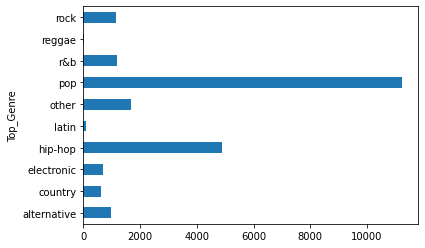

In [228]:
full_df.groupby("Top_Genre").count().Song.plot(kind="barh", use_index=True)

In [229]:
full_df.iloc[:25, 8:]

,SongID,Week_No,spotify_genre,album,explicit,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,Top_Genre
0,I'm Your AngelR. Kelly & Celine Dion,00,[],R.,False,332066.0,56.0,0.620,0.504,0.0,-7.260,1.0,0.0301,0.669000,0.000000,0.1100,0.266,112.681,4.0,other
1,Nobody's Supposed To Be HereDeborah Cox,00,"['canadian pop', 'hip pop', 'new jack swing', ...",One Wish,False,262333.0,54.0,0.662,0.531,8.0,-5.300,1.0,0.0361,0.202000,0.000012,0.5950,0.399,119.957,4.0,r&b
2,LatelyDivine,00,"['desi hip hop', 'desi pop']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
3,...Baby One More TimeBritney Spears,00,"['dance pop', 'pop', 'post-teen pop']",...Baby One More Time (Digital Deluxe Version),False,211066.0,77.0,0.759,0.699,0.0,-5.745,0.0,0.0307,0.202000,0.000131,0.4430,0.907,92.960,4.0,pop
4,Because Of You98 Degrees,00,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
5,From This Moment OnShania Twain,00,"['canadian country', 'canadian pop', 'country'...",Greatest Hits,False,235106.0,66.0,0.460,0.505,9.0,-5.487,1.0,0.0266,0.420000,0.000000,0.1340,0.220,135.757,4.0,country
6,Doo Wop (That Thing)Lauryn Hill,00,"['conscious hip hop', 'dance pop', 'hip pop', ...",The Miseducation of Lauryn Hill,False,320266.0,74.0,0.535,0.505,2.0,-8.926,0.0,0.2450,0.039300,0.000000,0.0923,0.495,99.935,4.0,hip-hop
7,Trippin'Total Featuring Missy Elliott,00,"['hip hop', 'hip pop', 'neo soul', 'new jack s...",Kim,False,267328.0,43.0,0.753,0.831,11.0,-6.431,0.0,0.0958,0.173000,0.000012,0.0927,0.505,124.151,4.0,r&b
8,Have You Ever?Brandy,00,"['dance pop', 'hip hop', 'hip pop', 'neo soul'...",Never Say Never,False,273440.0,61.0,0.698,0.533,2.0,-6.246,1.0,0.0437,0.542000,0.000000,0.3330,0.275,134.001,4.0,pop
9,Love Like ThisFaith Evans,00,"['dance pop', 'hip hop', 'hip pop', 'neo soul'...",Keep The Faith,False,275706.0,64.0,0.767,0.551,0.0,-7.328,1.0,0.0616,0.003640,0.000000,0.0451,0.796,100.904,4.0,r&b
